In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [103]:
df = pd.read_csv('AntibioticSales.csv')

# EDA

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    204 non-null    object 
 1   Time    204 non-null    int64  
 2   Month   204 non-null    int64  
 3   Year    204 non-null    int64  
 4   Sales   204 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 8.1+ KB


In [105]:
df.isnull().sum()

Date     0
Time     0
Month    0
Year     0
Sales    0
dtype: int64

In [106]:
df.describe()

,Time,Month,Year,Sales
count,204.000000,204.000000,204.000000,204.000000
mean,102.500000,6.500000,1999.500000,10.694430
std,59.033889,3.460545,4.936543,5.956998
min,1.000000,1.000000,1991.000000,2.814520
25%,51.750000,3.750000,1995.000000,5.844095
50%,102.500000,6.500000,1999.500000,9.319345
75%,153.250000,9.250000,2004.000000,14.289964
max,204.000000,12.000000,2008.000000,29.665356


In [107]:
df.head()

,Date,Time,Month,Year,Sales
0,07/1991,1,7,1991,3.526591
1,08/1991,2,8,1991,3.180891
2,09/1991,3,9,1991,3.252221
3,10/1991,4,10,1991,3.611003
4,11/1991,5,11,1991,3.565869


In [108]:
df.columns

Index(['Date', 'Time', 'Month', 'Year', 'Sales'], dtype='object')

In [109]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
df.set_index('Date', inplace=True)
ts = df['Sales']


In [110]:
sns.set(style="whitegrid")

In [111]:
print("Summary Statistics:\n", ts.describe())

Summary Statistics:
 count    204.000000
mean      10.694430
std        5.956998
min        2.814520
25%        5.844095
50%        9.319345
75%       14.289964
max       29.665356
Name: Sales, dtype: float64


Summary Statistics:
 count    204.000000
mean      10.694430
std        5.956998
min        2.814520
25%        5.844095
50%        9.319345
75%       14.289964
max       29.665356
Name: Sales, dtype: float64


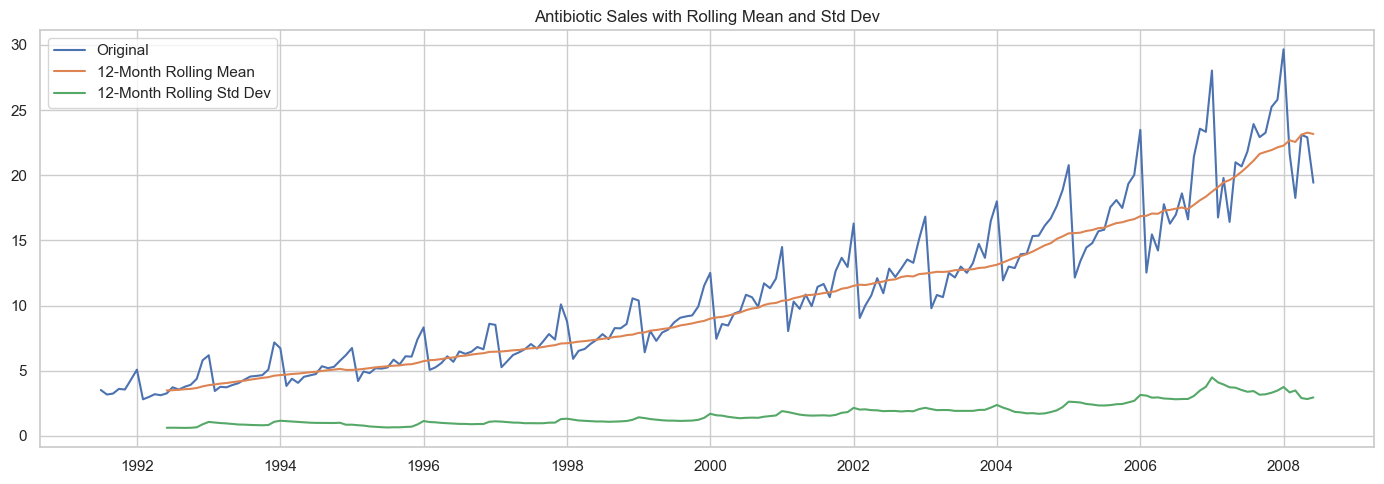

In [112]:

# Summary stats
print("Summary Statistics:\n", ts.describe())

# Rolling mean & std
ts_rolling_mean = ts.rolling(window=12).mean()
ts_rolling_std = ts.rolling(window=12).std()

plt.figure(figsize=(14, 5))
plt.plot(ts, label="Original")
plt.plot(ts_rolling_mean, label="12-Month Rolling Mean")
plt.plot(ts_rolling_std, label="12-Month Rolling Std Dev")
plt.title("Antibiotic Sales with Rolling Mean and Std Dev")
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
from statsmodels.tsa.stattools import adfuller

In [114]:
def test_stationarity(ts):
    dftest= adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [115]:
print("Results of Dickey-Fuller Test:")
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   3.145186
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [116]:
#it is not stationary so 
ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()
ts_log_diff_seasonal = ts_log_diff.diff(12).dropna()



In [117]:
print("Results of Dickey-Fuller Test:")
test_stationarity(ts_log_diff_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                  -4.785546
p-value                          0.000058
#Lags Used                      13.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


## Arima snd Sarima building and modeling

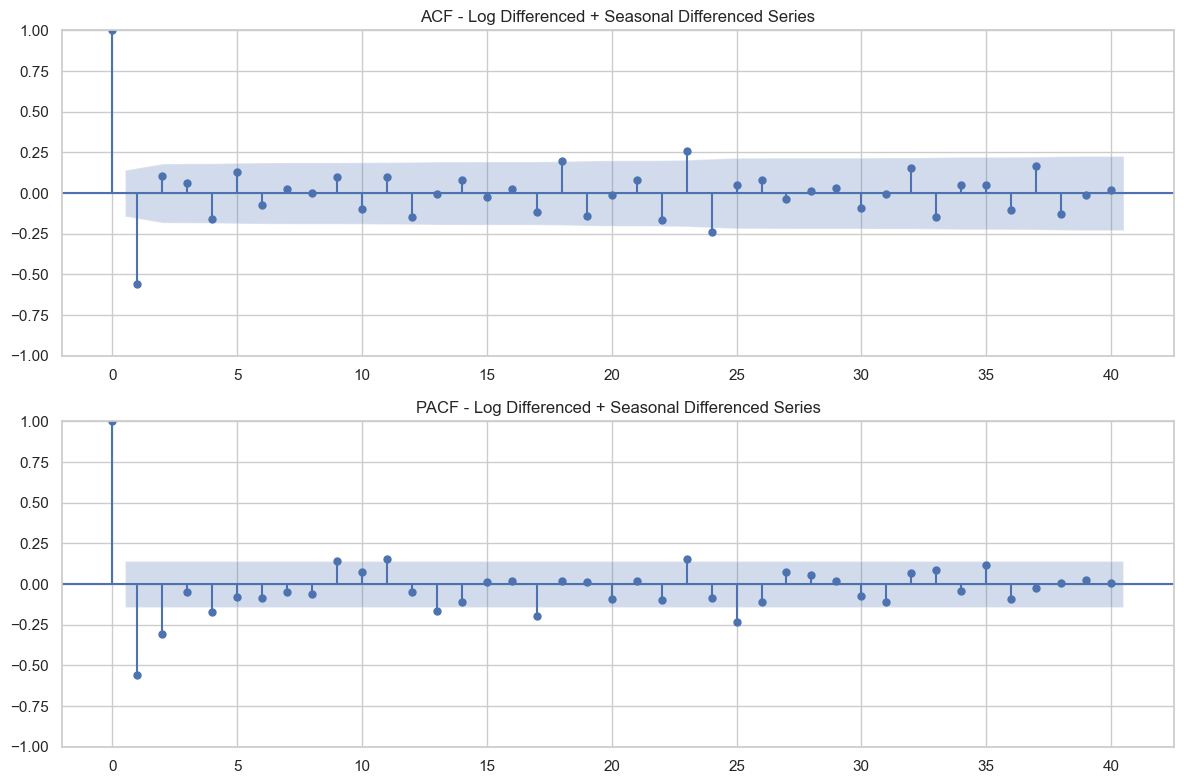

In [118]:



# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF: helps determine MA(q)
plot_acf(ts_log_diff_seasonal, lags=40, ax=axes[0])
axes[0].set_title("ACF - Log Differenced + Seasonal Differenced Series")

# PACF: helps determine AR(p)
plot_pacf(ts_log_diff_seasonal, lags=40, ax=axes[1])
axes[1].set_title("PACF - Log Differenced + Seasonal Differenced Series")

plt.tight_layout()
plt.show()


In [119]:
split_index = int(len(ts_log) * 0.8)  # 80% for training
# 20% for testing
ts_train = ts_log.iloc[:split_index]
ts_test = ts_log.iloc[split_index:]

In [120]:
forecast_start = ts_test.index[0]
forecast_end = ts_test.index[-1]

In [129]:
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA model
arima_model = ARIMA(ts_train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_prediction_log = arima_result.predict(start=forecast_start, end=forecast_end)
arima_prediction = np.exp(arima_prediction_log)


c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMA(1,1,1)(1,1,1)[12]
sarima_model = SARIMAX(ts_train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_prediction_log = sarima_result.predict(start=forecast_start, end=forecast_end)
sarima_prediction = np.exp(sarima_prediction_log)


c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA RMSE: 4.865821293164284 | MAE: 3.833289859948439 | R2: -0.38626194742571385
SARIMA RMSE: 1.5193909795786171 | MAE: 1.2120723284305548 | R2: 0.8648325625308717


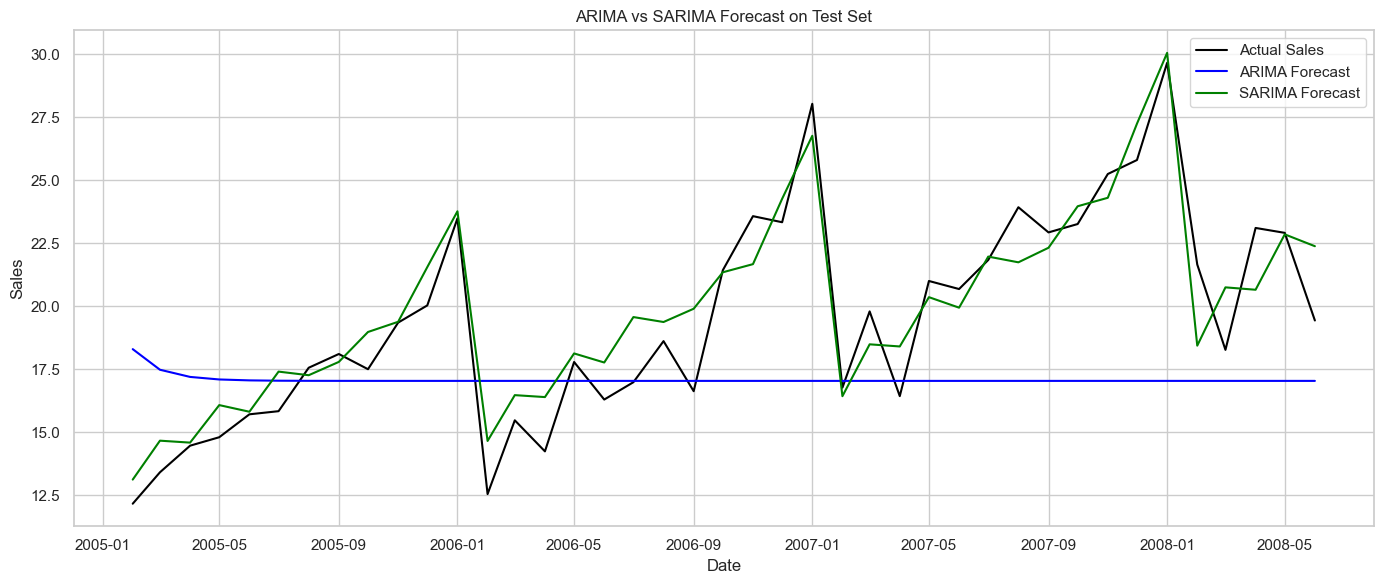

In [130]:
actual = np.exp(ts_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
arima_rmse = np.sqrt(mean_squared_error(actual, arima_prediction))
sarima_rmse = np.sqrt(mean_squared_error(actual, sarima_prediction))
arima_mae = mean_absolute_error(actual, arima_prediction)
sarima_mae = mean_absolute_error(actual, sarima_prediction)
r2_sarima = r2_score(actual, sarima_prediction)
r2_arima = r2_score(actual, arima_prediction)

print("ARIMA RMSE:", arima_rmse, "| MAE:", arima_mae, "| R2:", r2_arima)
print("SARIMA RMSE:", sarima_rmse, "| MAE:", sarima_mae, "| R2:", r2_sarima)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual Sales", color="black")
plt.plot(actual.index, arima_prediction, label="ARIMA Forecast", color="blue")
plt.plot(actual.index, sarima_prediction, label="SARIMA Forecast", color="green")
plt.title("ARIMA vs SARIMA Forecast on Test Set")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the evaluation metrics and visual inspection, it is clear that the SARIMA(1,1,1)(1,1,1)[12] model significantly outperforms the ARIMA(1,1,1) model for forecasting antibiotic sales. The SARIMA model achieved a much lower RMSE (1.52 vs. 4.87) and MAE (1.21 vs. 3.83), indicating that its predictions are closer to the actual values. Furthermore, the R² score for SARIMA was 0.8648, meaning it explains approximately 86% of the variance in the test data. In contrast, ARIMA yielded a negative R² score (-0.386), suggesting it performs worse than simply predicting the average. The SARIMA model also visually aligns more closely with the seasonal patterns in the actual data, while ARIMA fails to capture these dynamics and instead produces a nearly flat forecast. These results confirm that SARIMA is the more accurate and appropriate model for this seasonal time series.